In [1]:
from __future__ import division
from importlib import reload
from modules import * 

import csv
import pickle
fig_savedir = '../data/figures/'

In [ ]:
grid_params = {
    'y_height':     20, 
    'x_width':      20,
    'walls':        False,
    'rho':          0,
    'maze_type':    'none',
    'port_shift':   'none' 
}

#make environment
maze = eu.gridworld(grid_params)

In [ ]:
agent_params = {
    'load_model':   False,
    'load_dir':     '../data/outputs/gridworld/open_field{}{}.pt'.format(grid_params['x_width'],grid_params['y_height']),
    'rwd_placement':'training_loc',
    'action_dims':  len(maze.actionlist),
    'lin_dims':     500,
    'batch_size':   1,
    'gamma':        0.98, #discount factor
    'eta':          5e-4,
    'temperature':  1,
    'use_EC':       False,
    'cachelim':     100, # memory limit should be ~75% of #actions x #states
    'state_type':   'conv'
}

## some stupid reward placement shit -- replace later
if agent_params['load_model'] == True:
    if agent_params['rwd_placement'] == 'training_loc':
        maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
    if agent_params['rwd_placement'] == 'moved_loc':
        maze.set_rwd([(int(grid_params['y_height']/4),int(3*grid_params['x_width']/4))])
else:
    maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])

# make agent 
agent_params = sg.gen_input(maze, agent_params)
MF,opt = ac.make_agent(agent_params, freeze=False)

if agent_params['use_EC']:
    agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))
    agent_params['EC'] = ec.ep_mem(MF,agent_params['cachelim'])

(10, 19)


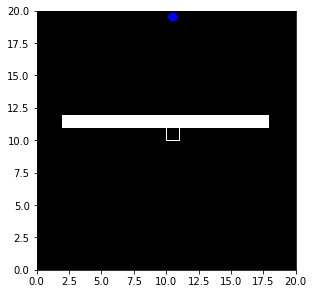

NameError: name 'sg' is not defined

In [ ]:
run_dict = {
    'NUM_EVENTS':   350,
    'NUM_TRIALS':   1500,
    'environment':  maze,
    'agent':        MF,
    'optimizer':    opt,
    'agt_param':    agent_params
}

In [ ]:
expt.run_tuncated_trials(run_dict)

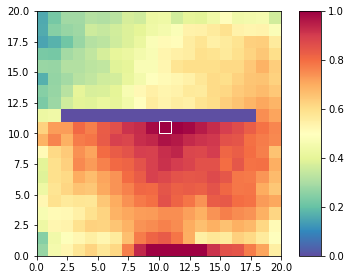

In [57]:
v_a, p_a = ac.snapshot(maze,MF)
gp.plot_valmap(maze, v_a)
gp.plot_polmap(maze, p_a)

Help on function plot_env in module gridworld_plotting:

plot_env(maze, save=False)
    :param maze: the environment object
    :param save: bool. save figure in current directory
    :return: None



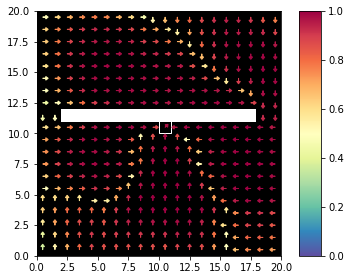

In [51]:
run_trials(run_dict, False) #false = mf only, true = w ec

[14:02:53]  Trial 1 TotRew = 0.95 (0.036s)
[14:02:55]  Trial 101 TotRew = 0.87 (2.107s)
[14:02:57]  Trial 201 TotRew = 0.87 (2.265s)
[14:03:00]  Trial 301 TotRew = 0.96 (2.126s)
[14:03:02]  Trial 401 TotRew = 0.9299999999999999 (2.893s)
[14:03:06]  Trial 501 TotRew = 0.96 (3.200s)
[14:03:08]  Trial 601 TotRew = 0.87 (2.799s)
[14:03:12]  Trial 701 TotRew = 0.85 (3.234s)
[14:03:15]  Trial 801 TotRew = 0.91 (3.069s)
[14:03:17]  Trial 901 TotRew = 0.89 (2.732s)
[14:03:20]  Trial 1000 TotRew = 0.98 (2.877s)


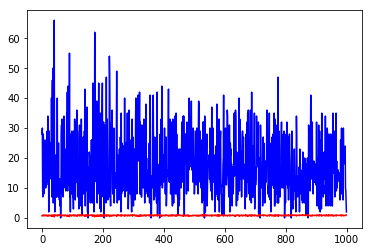

In [25]:
#print(len(EC.cache_list.keys()))
#print(run_dict['comp_mfec'])
plt.plot(run_dict['trial_length'], 'b')
plt.plot(run_dict['total_reward'], 'r')

In [ ]:
c_ec = EC.cache_list.values()

In [ ]:
start_buffer = 6
a = maze.rwd_loc[0][0]
b = np.random.choice([-1,1])
c = np.random.choice(list(np.arange(start_buffer)))
start_x = a + b*c
if start_x < 0:
    start_x = 0
elif start_x > maze.grid.shape[1]-1:
    start_x =maze.grid.shape[1]-1
print(start_x)


In [ ]:
cme = run_dict['comp_mfec']
pickle.dump(cme, open('mf_run.p', 'wb'))

In [ ]:
temp= 1
compare_policies = {}
for i in range(len(EC.cache_list.keys())):
    item = EC.cache_list[list(EC.cache_list.keys())[i]]
    compare_policies[item[2]] = [ec.softmax(np.nan_to_num(item[0][:,0]), T = temp), item[1]]

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
cmap = plt.cm.Spectral_r
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap = cmap)

ax1 = fig.add_axes([0.04, 0, 0.85, 0.85])
axc = fig.add_axes([0.85, 0, 0.05, 0.85])

cb1 = colorbar.ColorbarBase(axc, cmap = cmap, norm = cNorm)
ax1.imshow(maze.grid, vmin=0, vmax=1, cmap='bone', interpolation='none')

for entry in compare_policies.keys():
    x = entry[0]
    y = entry[1]
    
    ec_policy = compare_policies[entry][0]
    action = np.argmax(ec_policy)
    prob = max(ec_policy)
    
    timestamp = compare_policies[entry][1]
    
    
    
    dx1, dy1, head_w, head_l = gp.make_arrows(action,prob)
    if prob > 1/100:
        if (dx1, dy1) == (0,0):
            pass
        else:
            colorVal1 = scalarMap.to_rgba(prob)
            ax1.add_patch(patches.Rectangle([x,y],1,1, fc = colorVal1))
            ax1.annotate(f'{timestamp}', np.add((x,y), (0.45, 0.45)), size=26)
            #ax1.arrow(x,y, dx1, dy1, head_width=0.3, head_length=0.2, color = colorVal1)
    else:
        pass
ax1.add_patch(patches.Circle(maze.rwd_loc[0], 0.35, fc='w'))
ax1.invert_yaxis()

#f, axar = plt.subplots(len(EC.cache_list.keys()), 1, sharex=True, sharey=True)
#for i, entry in enumerate(compare_policies.keys()):    
#    axar[i].bar(np.arange(6), compare_policies[entry])
#axar[0].set_ylim([0,1])
plt.show()
plt.close()

In [ ]:
temp= 1
compare_policies = {}
for i in range(len(EC.cache_list.keys())):
    item = EC.cache_list[list(EC.cache_list.keys())[i]]
    compare_policies[item[2]] = ec.softmax(np.nan_to_num(item[0][:,0]), T = temp)

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
cmap = plt.cm.Spectral_r
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap = cmap)

ax1 = fig.add_axes([0.04, 0, 0.85, 0.85])
axc = fig.add_axes([0.85, 0, 0.05, 0.85])

cb1 = colorbar.ColorbarBase(axc, cmap = cmap, norm = cNorm)
ax1.imshow(maze.grid, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax1.add_patch(patches.Circle(maze.rwd_loc[0], 0.35, fc='w'))

for entry in compare_policies.keys():
    x = entry[0]
    y = entry[1]
    
    ec_policy = compare_policies[entry]
    action = np.argmax(ec_policy)
    prob = max(ec_policy)
    
    dx1, dy1, head_w, head_l = gp.make_arrows(action,prob)
    if prob > 1/100:
        if (dx1, dy1) == (0,0):
            pass
        else:
            colorVal1 = scalarMap.to_rgba(prob)
            ax1.arrow(x,y, dx1, dy1, head_width=0.3, head_length=0.2, color = colorVal1)
    else:
        pass

ax1.invert_yaxis()

#f, axar = plt.subplots(len(EC.cache_list.keys()), 1, sharex=True, sharey=True)
#for i, entry in enumerate(compare_policies.keys()):    
#    axar[i].bar(np.arange(6), compare_policies[entry])
#axar[0].set_ylim([0,1])
plt.show()
plt.close()

In [ ]:
plt.plot(run_dict['total_reward'], label='r')
#plt.plot(run_dict['total_loss'][0], label='p')
#plt.plot(run_dict['total_loss'][1], label='v')
plt.legend(bbox_to_anchor=(1.1,1.1))


In [ ]:
#early_learn_mf_only = run_dict['total_reward']
#early_learn_w_ec = run_dict['total_reward']
#late_learn_mf_only = run_dict['total_reward']
#late_learn_w_ec = run_dict['total_reward']

In [ ]:
print(len(run_dict['total_reward']))

In [ ]:
fig, ax = plt.subplots(2,1, sharex = True, sharey=True)
ax[0].plot(early_learning_w_ec, 'b', alpha =0.7, label = 'With EC')
ax[0].plot(early_learn_mf_only, 'k--', alpha = 0.7, label="MF only")

ax[1].plot(late_learn_w_ec, 'r', label='With EC')
ax[1].plot(late_learn_mf_only, 'k--', alpha = 0.7, label ='MF only')

ax[0].legend(bbox_to_anchor = (1.0,.75))
ax[1].legend(bbox_to_anchor = (1.0,.75))
fig.savefig('compare.svg', format='svg')

In [ ]:
c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])

lc = mc.LineCollection(lines, colors=c, linewidths=2)
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

In [ ]:
lines = [[(0, 1), (1, 1)], [(2, 3), (3, 3)], [(1, 2), (1, 3)]]
linepoints[4] = (0,1)

In [ ]:
print(len(DND.cache_list))
def cosine_sim(mem_dict, key, **kwargs):
    similarity_threshold = kwargs.get('threshold', 0.9)

    mem_cache = np.asarray(list(mem_dict.keys()))
    print(mem_cache.shape)
    entry = np.asarray(key)

    mqt = np.dot(mem_cache, entry)
    norm = np.linalg.norm(mem_cache, axis=1) * np.linalg.norm(entry)

    cosine_similarity = mqt / norm

    index = np.argmax(cosine_similarity)
    similar_activity = mem_cache[index]
    if max(cosine_similarity) >= similarity_threshold:
        return similar_activity, index, max(cosine_similarity)

    else:
        # print('max memory similarity:', max(cosine_similarity))
        return [], [], max(cosine_similarity)

def make_pvals(p, **kwargs):
    envelope = kwargs.get('envelope', 50)
    return np.round(1 / np.cosh(p / envelope),8)

def softmax(x, T=1):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp((x - np.max(x))/T)
    return e_x / e_x.sum(axis=0) 


In [ ]:
state_key, ind, max_cs = cosine_sim(DND.cache_list, sts[0])
print('sim', max_cs)
memory = np.nan_to_num(DND.cache_list[tuple(state_key)][0])
deltas = memory[:,0]
print(deltas)
rec_times = memory[:,1]
print("rtimes",rec_times)
times        = abs(timestep - memory[:,1])
print('tiems', times)
pv =make_pvals(times)
print(pv)

mult = np.multiply(deltas, pv)
print(softmax(max_cs*mult))

In [ ]:

for i in sts[0:10]:
    timestep = 1000
    a = DND.recall_mem(key=i,timestep=timestep,env=100)
    print(a,"----\n")

In [ ]:
cs =['r','g','b','c', 'y','pink']
'''
r = list(self.cache_list.keys())
g = [t for e, t in self.cache_list.values()]
b = lp = persistence_.index(min(persistence_))
c = old_activity = cache_keys[lp]
y = del self.cache_list[old_activity]
'''
plt.figure()
for i in range(len(EC.stupid_df)):
    xs = np.arange(len(EC.stupid_df[i]))
    ys = EC.stupid_df[i]
    
    plt.scatter(xs, ys, c=cs[i], alpha=0.3)
plt.ylim([-0.00002,0.00002])
plt.show()

In [ ]:
plt.figure(1)
plt.plot(run_dict['total_reward'])
plt.ylim([0,run_dict['NUM_EVENTS']])
 
plt.figure(2)
plt.plot(run_dict['total_loss'][0], label = 'pol')
plt.plot(run_dict['total_loss'][1], label = 'val')
plt.legend(loc=0)
plt.show()
plt.close()
#gp.print_value_maps(maze, run_dict['val_maps'], maps=0, val_range=(-1,50), save_dir=fig_savedir, title='Value Map')

In [59]:
ac.torch.save(MF,agent_params['load_dir'])